---
layout: default
title: "Anomaly Detection"
categories: anomaly
permalink: /ML24/
order: 24
comments: true
---

In [126]:
%pylab --no-import-all inline
plt.rcParams["mathtext.fontset"] = "cm"
from scipy.signal import gaussian
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Anomaly Detection
Anomaly detection describes a class of problems that many consider unsupervised but also have some aspect of supervised problems.

Anomaly detection is best explained through an example: suppose you are a aircraft engine manufacturer and, as part of your quality assurance testing, you measure a set of features of your manufactured engines. For this example the heat generated $x_1$ and the vibration intensity $x_2$.

The results of your measurements is a dataset $\left \lbrace x^{(1)}, x^{(2)}, \ldots, x^{(m)} \right \rbrace$ (<a href="#engines">figure below</a>)

In [28]:
mu, sigma = 0, 0.01 # mean and standard deviation
data = np.random.default_rng().normal(mu, sigma, (50, 2))

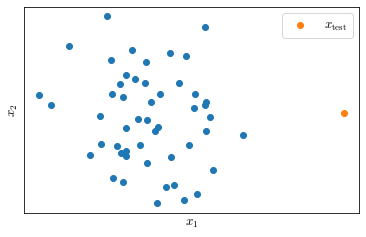

In [39]:
fig, ax = plt.subplots()
ax.scatter(*data.T)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.scatter(.05, 0, label='$x_\\mathrm{test}$')
ax.legend(fontsize=13);

<i id="engines">Results of quality assurance measurements performed on newly manufactured engines plotted in their features space $x_1, x_2$ and a new engine $x_\text{test}$</i>

Given a new example $x_\text{test}$, anomaly detection tries to answer the question: is the new example anomalous in any way?

In order to answer this question we are going to build a model of the probability of $x$ to be in a specific point of the feature space $p(x)$; If $p(x_\text{test}) < \varepsilon$ we will flag it as an anomaly (where $\varepsilon$ is a small number).

## Gaussian Distribution
Suppose $x \in \mathbb{R}$. If $x$ distributes as a Gaussian distributions with mean $\mu$ and variance $\sigma^2$, it means that its distributes resembles that in <a href="#gaussian">the figure below</a>.

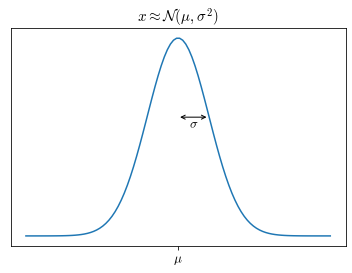

In [231]:
fig, ax = plt.subplots()
ax.plot(np.linspace(-.5, .5, 100), gaussian(100, std=10));
ax.set_title(r'$x \approx \mathcal{N}(\mu, \sigma^2)$', fontsize=15)
ax.set_xticks([0])
ax.set_yticks([])
ax.set_xticklabels(['$\\mu$'], fontsize=13)
ax.annotate(text='', xy=(0.0, .6), xytext=(0.1, .6), arrowprops=dict(arrowstyle='<->'))
ax.text(0.05, .6, '$\sigma$', va='top', ha='center', fontsize=13);

<i id="gaussian">Gaussian distribution with mean $\mu$ and variance $\sigma^2$</i>

The function of the Gaussian distribution is

$$
p(x;\mu, \sigma^2)=\frac{1}{\sigma \sqrt{2 \pi}}  \left( - \frac{(x-\mu)^2}{2\sigma^2} \right)
$$

## Parameter estimation
Suppose you have a dataset $\lbrace x^{(1)}, x^{(2)}, \ldots, x^{(m)} \rbrace$ with $x^{(i)} \in \mathbb{R}$ (<a href="#paramestim">figure below</a>) and you suspect that they are Gaussian distributed with each $x^{(i)} \approx \mathcal{N}(\mu, \sigma^2)$ but I don't know the values of the two parameters $\mu$ and $\sigma^2$

In [106]:
x = np.random.default_rng().normal(0, .1, 50)

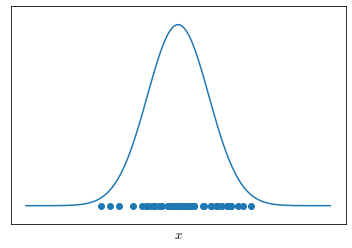

In [147]:
fig, ax = plt.subplots()
ax.scatter(x, np.zeros_like(x))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('$x$', fontsize=13)
ax.set_ylim(-0.1, 1.1)
ax.plot(np.linspace(-.5, .5, 100), gaussian(100, std=10));

<i id="paramestim">Data distributed on the $x$ axis and their Gaussian density estimation</i>

The parameters can be estimated from $x$, we will have

$$
\mu= \frac{1}{m} \sum^m_{i=1}x^{(i)}  \qquad \qquad \sigma^2 = \frac{1}{m}\sum^m_{i=1}(x^{(i)} - \mu)^2
$$

## Anomaly detection algorithm
Given a $m \times n$ training set $x \in \mathbb{R}^n$

The anomaly detection algorithm requires that parameters are fitted **for each feature $x_j$**:

$$
\mu_j= \frac{1}{m} \sum^m_{i=1}x_j^{(i)}  \qquad \qquad \sigma_j^2 = \frac{1}{m}\sum^m_{i=1}(x_j^{(i)} - \mu_j)^2
$$

Then, Given a  new example $x$, compute $p(x)$:

$$
\begin{align}
p(x) & = p(x_1; \mu_1,\sigma^2_1)p(x_2; \mu_2,\sigma^2_2),\ldots,p(x_n; \mu_n,\sigma^2_n) \\
& = \prod^n_{j=1}p(x_j; \mu_j,\sigma^2_j) \\
& = \prod^n_{j=1}\frac{1}{\sigma_j \sqrt{2 \pi}}  \left( - \frac{(x_j-\mu_j)^2}{2\sigma_j^2} \right)
\end{align}
$$

### Evaluation
Anomaly detection algorithm can be evaluated with a confusion matrix given that some anomalous data is included in the training, in the test and cross-validation sets. The number of anomalous examples can be very small (e.g. 1:1000) but it is useful when evaluating.

Evaluation on test / cross-validation set can the be based on the raw numbers of the confusion matrix, on precision/recall or $F_1$-Score metrics.

The cross-validations set can be used to choose the parameter $\varepsilon$

## Anomaly Detection vs Supervised Learning
In order to evaluate an anomaly detection model we need some labeled data. Then why don't we use a supervised classification algorithm to detect anomalous data points?

|           | Anomaly detection                                                                                                                                                                                                                                | Supervised learning                                                                                                                                                                      |
|-----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Imbalance | Commonly, you have a very small number of positive examples (0-20) and  a large number of negative examples.                                                                                                                                     | You have a large number of positive and negative examples                                                                                                                                |
| Coverage  | There may be many different types of anomalies. It may be hard for any algorithm to learn from positive examples what do the anomalies look like. Furthermore, future anomalies may look nothing like any anomalous example in the training set. | You have enough positive examples for an algorithm to get a sense of what positive examples are like; future positive examples are likely to be similar to the ones in the training set. |

## Selecting Features for anomaly detection
The choice of features included in an anomaly detection model heavily impact its performance.

The most common problem that we want to overcome and is caused by a sub-optimal choice of the features is that $p(x)$ assumes comparable values for normal and anomalous examples.

Usually the best procedure to choose features is by an error analysis, which is best explained in the <a href="#erroranalysis">figure below</a>

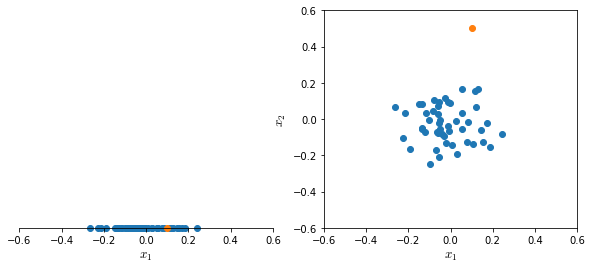

In [247]:
x1, x2 = np.random.default_rng().normal(0, .1, (2, 50))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

a = [.1, .5]
ax1.scatter(x1, np.zeros_like(x1), clip_on=False)
ax1.scatter(a[0], 0, clip_on=False)
ax1.set_ylim(0, .6)
ax1.set_xlim(-.6, .6)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
#ax1.spines['bottom'].set_position('center')
ax1.set_yticks([])
ax1.set_xlabel('$x_1$', fontsize=13)

ax2.scatter(x1, x2)
ax2.scatter(*a)
ax2.set_xlim(-.6, .6)
ax2.set_ylim(-.6, .6)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13);

<i id="erroranalysis">An anomalous example not detected with a single feature $x_1$ and correctly detected in the feature space $x_1, x_2$</i>

A good practice in choosing features is to choose or combine features so that they take on unusually large or small values in the event of an anomaly.

## Non-Gaussian features
Even if a feature has not a Gaussian distribution (<a href="#gaussbetadist">figure below</a>), usually the algorithm works fine. However, usually the algorithm will work better if non-Gaussian data is **transformed to Gaussian**.

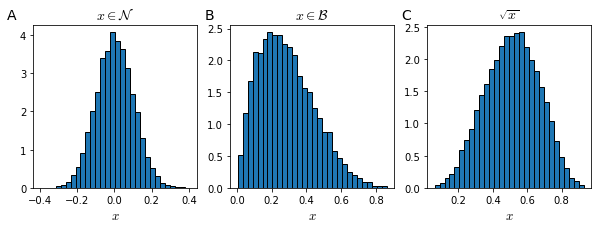

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
ax1, ax2, ax3 = axes

g = np.random.default_rng().normal(0, .1, 10000)
b = np.random.default_rng().beta(2, 5, 10000)
t = b**.5

titles = [
    "$x \\in \\mathcal{N}$",
    "$x \\in \\mathcal{B}$",
    "$\\sqrt{x}$"
]

for ax, dist, l, t in zip(axes, [g, b, t], ['A', 'B', 'C'], titles):
    ax.hist(dist, bins=30, edgecolor='k', density=True)
    ax.set_xlabel('$x$', fontsize=13)
    ax.text(-0.1, 1.1, l, transform=ax.transAxes,
      fontsize=14, va='top', ha='right')
    ax.set_title(t, fontsize=14)

<i id="gaussbetadist">Histogram of data drawn from a Gaussian (A) and Beta (B) distributions and from the Beta distribution transformed to Gaussian (C)</i>